# Claim2Features

## Util

### Ignore Warning

In [1]:
import warnings
warnings.filterwarnings("ignore")

### My Hot Encoder Decoder

In [2]:
import numpy as np
from collections import OrderedDict
from operator import itemgetter


def myHotEncode(input_data, max_vocab=0, vocab2idx=None):
    "Return the hot-vecotor and the vocab2idx."
    if vocab2idx is None:
        vocabFreq = {}
        for i in input_data:
            for j in i:
                if j not in vocabFreq:
                    vocabFreq[j] = 0
                vocabFreq[j] += 1
        vocabFreq = OrderedDict(sorted(vocabFreq.items(), key=itemgetter(1), reverse=True))
        vocab2idx = {}
        count = 0
        for v in vocabFreq:
            count += 1
            if max_vocab > 0 and count > max_vocab:
                break
            vocab2idx[v] = len(vocab2idx)        
    vocabEmbeddings = np.identity(len(vocab2idx), dtype='float32')
    data_ret = []
    for i in input_data:
        i_ = []
        for j in i:
            if j in vocab2idx:
                i_.append(vocabEmbeddings[vocab2idx[j]])
        if len(i_) == 0:
            i_ = np.zeros((1,len(vocab2idx)))
        data_ret.append(sum(i_))
    return data_ret, vocab2idx


def myHotDecode(input_data, vocab2idx):
    "Return the decode as final representation and decode as indexs"
    data_ = []
    data_idx = []
    for i in input_data:
        i_ = []
        i_idx = []
        if len(i) != len(vocab2idx):
            print('Erro:', 'The vocab2idx not fit the input data!')
            return
        for _i, j in enumerate(i):
            if j > 0:
                v = [k for k in vocab2idx if vocab2idx[k]==_i][0]
                i_.append(v)
                i_idx.append(_i)
        data_.append(i_)
        data_idx.append(i_idx)
    return data_, data_idx

### Confusion Matrix

In [15]:
import matplotlib.pyplot as plt
import itertools


def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

### Treat texts

#### Treat text or a list of texts

In [4]:
def treat_text(text, removes=['\n', '\r', '\t'], strip=True):
    if type(text) == list:
        text_ = []
        for t in text:
            text_.append(treat_text(t))
        return text_
    text_ = text
    for remove in removes:
        text_ = text_.replace(remove, ' ')
    if strip:
        text_ = text_.strip()
    return text_

#### Split pure words

In [5]:
def pure_words(text, dividers=['-', '_'], uppercase=True, low_upper=True):
    upper = list('ABCDEFGHIJKLMNOPQRSTUVWYZ')
    text_ = ''
    last_space = True
    for c in text:
        if not last_space:
            if c in dividers:
                text_ += ' '
            elif uppercase and c in upper:
                c_ = c
                if low_upper:
                    c_ = c.lower()
                text_ += ' ' + c_
            else:
                text_ += c
        else:
            if c not in dividers:
                text_ += c
        if c == ' ':
            last_space = True
        else:
            last_space = False
    return text_

## Pre-processing

In [19]:
%%time
import pandas as pd
import ast

data_path = 'dataset.csv'
df = pd.read_csv(data_path)

columns = ['tag', 'text', 'attrs', 'level', 'brother_tag', 'brother_text', 'brother_attrs', 'url', 'site', 'label']
words_context = []
brother_words_context = []

count = 0
for tupla in df[columns].values:
    count += 1
    # Each instance is a dictionary dic
    dic = {}
    for i, column in enumerate(columns):
        dic[column] = tupla[i]
    
    # words_context attribute
    words_context_ = ''
    if dic['text'] != 'None Text':
        words_context_ += pure_words(treat_text(str(dic['text']))) + ' '
    attrs = ast.literal_eval(dic['attrs'])
    for attr in attrs.values():
        if type(attr) == str:
            words_context_ += pure_words(treat_text(str(attr))) + ' '
        else:
            for a in attr:
                words_context_ += pure_words(treat_text(str(a))) + ' '
    words_context.append(words_context_)
    
    # brother_words_context attribute
    brother_words_context_ = ''
    if dic['brother_text'] != 'None Text':
        brother_words_context_ += pure_words(treat_text(str(dic['brother_text']))) + ' '
    attrs = ast.literal_eval(dic['brother_attrs'])
    for attr in attrs.values():
        if type(attr) == str:
            brother_words_context_ += pure_words(treat_text(str(attr))) + ' '
        else:
            for a in attr:
                brother_words_context_ += pure_words(treat_text(str(a))) + ' '
    brother_words_context.append(brother_words_context_)
    
del df['attrs']
del df['brother_attrs']
df['words_context'] = words_context
df['brother_words_context'] = brother_words_context

Wall time: 25.8 ms


## Features

### Bag-of-words for context words

In [20]:
%%time
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 


class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]


vocab_size = 2000
vec = CountVectorizer(max_features=vocab_size, stop_words=ENGLISH_STOP_WORDS, tokenizer=LemmaTokenizer())
vec.fit(df['words_context'])
words_context = vec.transform(list(df['words_context'])).toarray()
brother_words_context = vec.transform(list(df['brother_words_context'])).toarray()

Wall time: 413 ms


### Text size

In [21]:
text_sizes = []
for size in df['text']:
    if type(size) == str:
        text_sizes.append([len(size.strip().split(' '))])
    else:
        text_sizes.append([0])
brother_text_sizes = []
for size in df['brother_text']:
    if type(size) == str:
        brother_text_sizes.append([len(size.strip().split(' '))])
    else:
        brother_text_sizes.append([0])

### Tag

In [22]:
tag2Idx = myHotEncode([df['tag']], 100)[1]
tag = myHotEncode([[x] for x in df['tag']], vocab2idx=tag2Idx)[0]
brother_tag = myHotEncode([[x] for x in df['brother_tag']], vocab2idx=tag2Idx)[0]

### Level

In [23]:
level = df['level']

## SVM

### Data preparation

In [24]:
%%time
last_levels = [-1]
last_labels = ['None']

last_tags = []
last_text_sizes = []
last_words_contexts = []
last_brother_tags = []
last_brother_text_sizes = []
last_brother_words_contexts = []


def features(tag, text_size, words_context, level,
             brother_tag, brother_text_size, brother_words_context,
             parent_tag, parent_text_size, parent_words_context):
    # Tag
    #return list(tag)
    
    # Level
    #return [level]
    
    # Words Contexts
    #return list(words_context)
    
    # Text sizes
    #return list(text_size)

    # Brothers tags
    #return list(brother_tag)
    
    # Brothers text sizes
    #return list(brother_text_size)
    
    # Brothers words contexts
    #return list(brother_words_context)
    
    # Parent tag
    #return list(parent_tag)
    
    # Parent text size
    #return list(parent_text_size)
    
    # Parent words contexts
    #return list(parent_words_context)
    
    # All
    return list(tag) + list(text_size) + list(words_context) + [level] + list(brother_tag) + list(brother_text_size) + list(brother_words_context) + list(parent_tag) + list(parent_text_size) + list(parent_words_context)
    


X = []
X_ = []
y = []
group = []
last_group = None
last_url = 'NONE'

sizes = set()

for i in range(len(df)):
    if last_url != 'NONE' and df['url'][i] != last_url:
        if len(last_tags) > 0:
            # Parent
            if len(last_tags) > 1:
                parent_tag = last_tags[-2]
                parent_text_size = last_text_sizes[-2]
                parent_words_context = last_words_contexts[-2]
            else:
                print("here???")
                parent_tag = np.zeros(len(last_tags[-1]))
                parent_text_size = np.zeros(len(last_text_sizes[-1]))
                parent_words_contexts = np.zeros(len(last_words_contexts[-1]))
            x = features(last_tags[-1], last_text_sizes[-1], last_words_contexts[-1], last_levels[-1], 
                         last_brother_tags[-1], last_brother_text_sizes[-1], last_brother_words_contexts[-1],
                         parent_tag, parent_text_size, parent_words_context)
            X.append(x)
            X_.append(list(last_tags[-1]).index(1)) # Debug control
            sizes.add(len(x))
            y_ = 'None'
            for y__ in last_labels:
                if y__ != 'None':
                    y_ = y__
            y.append(y_)
            group.append(last_group)
            last_labels = ['None']
            last_tags = []
            last_text_sizes = []
            last_words_contexts = []
            last_levels = [-1]
            last_brother_tags = []
            last_brother_text_sizes = []
            last_brother_words_contexts = []
        last_url = df['url'][i]
        continue
        
    last_url = df['url'][i]
    level_ = df['level'][i]
    
    if level_ > last_levels[-1]:
        last_tags.append(tag[i])
        last_text_sizes.append(text_sizes[i])
        last_words_contexts.append(words_context[i])
        last_levels.append(level_)
        last_brother_tags.append(brother_tag[i])
        last_brother_text_sizes.append(brother_text_sizes[i])
        last_brother_words_contexts.append(brother_words_context[i])
        last_labels.append(df['label'][i])
            
    else:
        if len(last_tags) > 0:
            # Parent
            if len(last_tags) > 1:
                parent_tag = last_tags[-2]
                parent_text_size = last_text_sizes[-2]
                parent_words_context = last_words_contexts[-2]
            else:
                print("here???")
                parent_tag = np.zeros(len(last_tags[-1]))
                parent_text_size = np.zeros(len(last_text_sizes[-1]))
                parent_words_contexts = np.zeros(len(last_words_contexts[-1]))
            x = features(last_tags[-1], last_text_sizes[-1], last_words_contexts[-1], last_levels[-1], 
                         last_brother_tags[-1], last_brother_text_sizes[-1], last_brother_words_contexts[-1],
                         parent_tag, parent_text_size, parent_words_context)
            X.append(x)
            X_.append(list(last_tags[-1]).index(1))  # Debug control
            sizes.add(len(x))
            y_ = 'None'
            for y__ in last_labels:
                if y__ != 'None':
                    y_ = y__
            y.append(y_)
            group.append(last_group)
            # Remove last data used
            last_labels = last_labels[:level_-1]
            last_tags = last_tags[:level_-1]
            last_text_sizes = last_text_sizes[:level_-1]
            last_words_contexts = last_words_contexts[:level_-1]
            last_levels = last_levels[:level_-1]
            last_brother_tags = last_brother_tags[:level_-1]
            last_brother_text_sizes = last_brother_text_sizes[:level_-1]
            last_brother_words_contexts = last_brother_words_contexts[:level_-1]

            last_tags.append(tag[i])
            last_text_sizes.append(text_sizes[i])
            last_words_contexts.append(words_context[i])
            last_levels.append(level_)
            last_brother_tags.append(brother_tag[i])
            last_brother_text_sizes.append(brother_text_sizes[i])
            last_brother_words_contexts.append(brother_words_context[i])
            last_labels.append(df['label'][i])
    last_group = df['site'][i]

if len(last_tags) > 0:
    # Parent
    if len(last_tags) > 1:
        parent_tag = last_tags[-2]
        parent_text_size = last_text_sizes[-2]
        parent_words_context = last_words_contexts[-2]
    else:
        print("here???")
        parent_tag = np.zeros(len(last_tags[-1]))
        parent_text_size = np.zeros(len(last_text_sizes[-1]))
        parent_words_contexts = np.zeros(len(last_words_contexts[-1]))
    x = features(last_tags[-1], last_text_sizes[-1], last_words_contexts[-1], last_levels[-1], 
                 last_brother_tags[-1], last_brother_text_sizes[-1], last_brother_words_contexts[-1],
                 parent_tag, parent_text_size, parent_words_context)
    X.append(x)
    X_.append(list(last_tags[-1]).index(1)) # Debug control
    sizes.add(len(x))
    y_ = 'None'
    for y__ in last_labels:
        if y__ != 'None':
            y_ = y__
    y.append(y_)
    group.append(last_group)
    
X = np.array(X)
y = np.array(y)
group = np.array(group)

Wall time: 110 ms


### Train and Evaluation

Train Groups (URLs) {1, 2}
Test Groups (URLs) {0}


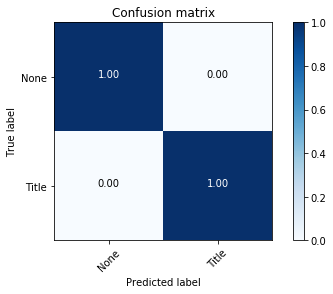

Acc: 100.00 %
Precision: 100.00 %
Recall: 100.00 %
F1: 100.00 %

Train Groups (URLs) {0, 2}
Test Groups (URLs) {1}


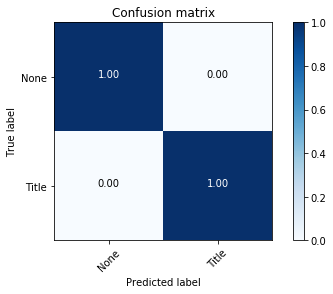

Acc: 100.00 %
Precision: 100.00 %
Recall: 100.00 %
F1: 100.00 %

Train Groups (URLs) {0, 1}
Test Groups (URLs) {2}


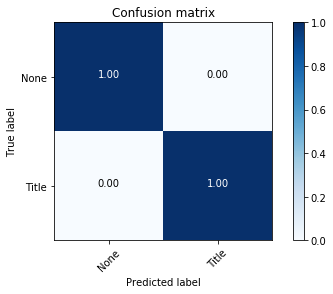

Acc: 100.00 %
Precision: 100.00 %
Recall: 100.00 %
F1: 100.00 %

Acc 100.00 % (+/- 0.00 %)
Precision 100.00 % (+/- 0.00 %)
Recall 100.00 % (+/- 0.00 %)
F1 100.00 % (+/- 0.00 %)


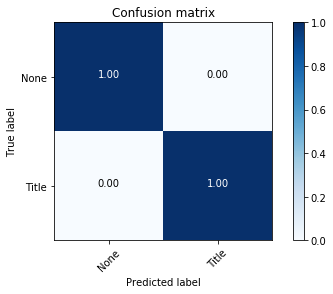

Wall time: 627 ms


In [26]:
%%time
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix


accuracy = []
precision = []
recall = []
f1 = []
confusion = []

# Aux print
_, site2Idx = myHotEncode([[u] for u in group])

gp = GroupKFold(n_splits=11)
for train_indexs, test_indexs in gp.split(X, groups=group):
    
    X_train = X[train_indexs]
    y_train = y[train_indexs]
    
    X_test = X[test_indexs]
    y_test = y[test_indexs]
    
    groups_train = group[train_indexs]
    groups_test = group[test_indexs]
    train_g = set()
    test_g = set()
    for g in groups_train:
        train_g.add(site2Idx[g])
    for g in groups_test:
        test_g.add(site2Idx[g])
    print('Train Groups (URLs)', train_g)
    print('Test Groups (URLs)', test_g)
    
    svm = LinearSVC()
    svm.fit(X_train, y_train)
    result = svm.predict(X_test)

    acc = accuracy_score(result, y_test)
    accuracy.append(acc)
    p = precision_score(result, y_test, average="macro")
    precision.append(p)
    r = recall_score(result, y_test, average="macro")
    recall.append(r)
    f = f1_score(result, y_test, average="macro")
    f1.append(f)
    cm_ = confusion_matrix(result, y_test)
    plot_confusion_matrix(cm_, svm.classes_, normalize=True) 
    confusion.append(cm_)
    
    print("%s: %.2f %%" % ('Acc', acc*100))
    print("%s: %.2f %%" % ('Precision', p*100))
    print("%s: %.2f %%" % ('Recall', r*100))
    print("%s: %.2f %%" % ('F1', f*100))
    print('')

print("Acc %.2f %% (+/- %.2f %%)" % (np.mean(accuracy)*100, np.std(accuracy)*100))
print("Precision %.2f %% (+/- %.2f %%)" % (np.mean(precision)*100, np.std(precision)*100))
print("Recall %.2f %% (+/- %.2f %%)" % (np.mean(recall)*100, np.std(recall)*100))
print("F1 %.2f %% (+/- %.2f %%)" % (np.mean(f1)*100, np.std(f1)*100))

nc = []
for c in confusion:
    d = len(svm.classes_) - len(c)
    c = np.pad(c, (0,d), 'constant')
    nc.append(c)
confusion = nc
cm = np.mean(confusion, axis=0)
plot_confusion_matrix(cm, svm.classes_, normalize=True) 

## Debug and Check data

In [ ]:
for x_, y_, g_ in zip(X,y,group):
    if y_ == 'Credibility' and g_ != 'checkyourfact':
        print(x_)

In [ ]:
svm.predict([[x__] for x__ in range(0,350)])

In [17]:
site2Idx

{'abc': 2,
 'africacheck': 5,
 'checkyourfact': 10,
 'factcheckni': 7,
 'fullfact': 9,
 'politifact': 1,
 'rappler': 0,
 'snope': 4,
 'theconversation': 3,
 'theferret': 6,
 'truthorfiction': 8}

In [ ]:
len(X)

In [ ]:
%%time
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix


accuracy = []
precision = []
recall = []
f1 = []
confusion = []

X_train = X[:20000]
y_train = y[:20000]
    
X_test = X[20000:]
y_test = y[20000:]

svm = RandomForestClassifier()
svm.fit(X_train, y_train)
result = svm.predict(X_test)

acc = accuracy_score(result, y_test)
accuracy.append(acc)
p = precision_score(result, y_test, average="macro")
precision.append(p)
r = recall_score(result, y_test, average="macro")
recall.append(r)
f = f1_score(result, y_test, average="macro")
f1.append(f)
confusion.append(confusion_matrix(result, y_test))
    
print("%s: %.2f %%" % ('Acc', acc*100))
print("%s: %.2f %%" % ('Precision', p*100))
print("%s: %.2f %%" % ('Recall', r*100))
print("%s: %.2f %%" % ('F1', f*100))
print('')

print("Acc %.2f %% (+/- %.2f %%)" % (np.mean(accuracy)*100, np.std(accuracy)*100))
print("Precision %.2f %% (+/- %.2f %%)" % (np.mean(precision)*100, np.std(precision)*100))
print("Recall %.2f %% (+/- %.2f %%)" % (np.mean(recall)*100, np.std(recall)*100))
print("F1 %.2f %% (+/- %.2f %%)" % (np.mean(f1)*100, np.std(f1)*100))

nc = []
for c in confusion:
    d = len(svm.classes_) - len(c)
    c = np.pad(c, (0,d), 'constant')
    nc.append(c)
confusion = nc
cm = np.mean(confusion, axis=0)
plot_confusion_matrix(cm, svm.classes_, normalize=True) 